In [191]:
from astropy.io import fits
import numpy as np
import logging
import os
import random
from matplotlib import pyplot as plt

from cube_fil_finder.structs import mask_obj_node_tree as maskTree
from cube_fil_finder.structs import util as struct_util
from cube_fil_finder.galfa import preprocess_cube, galfa_util
from cube_fil_finder.util import cube_util, tree_dict_util, moments
from cube_fil_finder.vis import node_vis

reload(tree_dict_util)

%matplotlib inline

In [87]:
logging.getLogger().setLevel('INFO')

In [2]:
high_lat_data_path = '../../debug/avery_test_cube/highlat_test.fits'

In [3]:
high_lat_data, header = fits.getdata(high_lat_data_path, header=True)

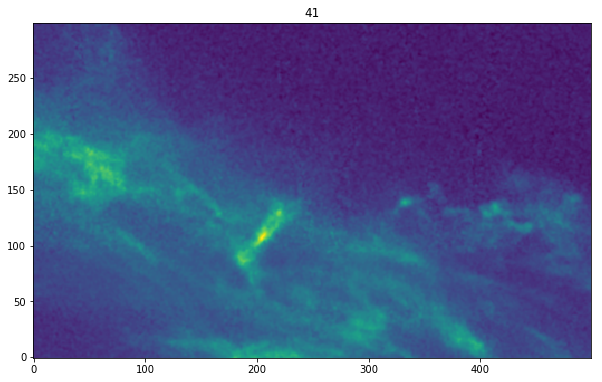

In [4]:
for i in range(41, 42):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(high_lat_data[i], origin='lower')
    ax.set_title(i)

In [5]:
def construct_filaments(vslice, header, v_channel):
    """
    Find a filamentary structure at a given velocity slice.
    
    Returns:
    node of masked objects (for the purpose of checking overlaps)
    """
    header['BUNIT'] = 'K' # to be read by astropy.units
    scale_width = 0.1 * u.pc # empirical 
    filament = FilFinder2D(vslice, header=header, distance=100.*u.pc, beamwidth=10.*u.arcmin)
    filament.preprocess_image(flatten_percent=95)
    filament_masks, corners = filament.create_mask(smooth_size = scale_width/2, adapt_thresh=scale_width*2, 
                         size_thresh= 8*(scale_width*2)**2, border_masking=False, output_mask_objs=True)
    
    nmasks = len(filament_masks)
    
    node_dict = {}
    if filament_masks is None:
        pass
    else:
        for i in range(nmasks):
            mask_node = maskNode.MaskObjNode(filament_masks[i], corners[i], v_channel)
            struct_util.add_node_to_dict(mask_node, node_dict)
    
    return node_dict

def noderun_for_multichannel_modified(valid_slices, header, save_path=None):
    """
    Run for multiple velocity slices
    """
    all_nodes = {}
    nch = len(valid_slices) ## number of velocity slices
    for i in range(nch):
    #for i in range(nch, 0, -1): ## reverse test
        node_one = construct_filaments(valid_slices[i], header, i)
        all_nodes[i] = node_one
    return all_nodes

def find_trees(nodes, overlap_thresh=.85, reverse_find=False):
    """
    Find trees from nodes
    """
    trees = {} ## individual tree
    connected_trees = set()
    
    vindex = nodes.keys() ## it is a list of velocity indices of a given node
    nchannel = len(vindex)
    
    for i in range(nchannel):
        current_node = nodes[vindex[i]]
        filaments = tree_dict_util.struct_util.sorted_struct_dict_keys_by_area(current_node, 'node')
        for j in filaments:
            mode = current_node[j]
            oldflag = tree_dict_util.match_and_add_node_onto_tree(mode, vindex[i], trees, overlap_thresh, continuous_trees=connected_trees)
            if not oldflag: # if tree is empty raise
                new_tree = maskTree.newTreeFromNode(mode, verbose=False)
                struct_util.add_tree_to_dict(new_tree, trees)
                
        connected_trees = tree_dict_util.end_noncontinuous_trees(trees, vindex[i])
        #tree_dict_util.delete_short_dead_trees(trees, verbose=False)
    
    return trees


def process_filaments(vslices, hdr, wkernel=15, overlap=0.85, usm_return=True):
    """
    Find filaments
    """
    usmed = np.zeros_like(vslices)
    for i in range(len(vslices)):
        usmed[i] = cube_util.umask(vslices[i], wkernel)
    
    nodes = noderun_for_multichannel_modified(usmed, hdr)
    pre_trees = find_trees(nodes, overlap_thresh=overlap)
    trees = filter_trees(pre_trees) # require length>2
    if usm_return is True:
        return trees, usmed
    else:
        return trees
        

def ordering_corners(corner):
    """
    Just place ordering in the right place for extent plotting
    """
    aligned = [corner[0][1], corner[1][1], corner[0][0], corner[1][0]]
    return aligned

In [6]:
data_subset = high_lat_data
usmed_data = np.zeros_like(data_subset)
for i in range(data_subset.shape[0]):
    usmed_data[i] = cube_util.umask(data_subset[i])

In [7]:
nodes_dicts = dict()
for v in range(usmed_data.shape[0]):
    nodes_dicts[v] = preprocess_cube.process_dataslice_filfind_struct(usmed_data[v], header, v)

In [8]:
# filter out nodes on the boundaries
nodes_dicts_clean = dict()
for v in nodes_dicts:
    nodes_dicts_clean[v] = {k: v for k, v in nodes_dicts[v].items()
                            if not(v.corners[0][0] <= 10
                                   or v.corners[0][1] <= 10
                                   or v.corners[1][0] >= 290
                                   or v.corners[1][1] >= 490)}

In [276]:
trees = find_trees(nodes_dicts_clean, overlap_thresh=.85)
for k in trees:
    trees[k].has_ended = True
tree_dict_util.delete_short_dead_trees(trees, size_cutoff=400)

INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:

INFO:root:match found -- tree 470_1_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 462_0_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1070_6_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 928_7_0
INFO:root:match found -- tree 1051_2_0
INFO:root:match found -- tree 470_1_0


INFO:root:match found -- tree 1070_6_0
INFO:root:match found -- tree 846_13_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 569_11_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1001_17_0
INFO:root:match found -- tree 569_11_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 923_15_0
INFO:root:match found -- tree 871_15_0
INFO:root:match found -- tree 788_17_0
INFO:root:match found -- tree 473_15_0
INFO:root:match found -- tree 1477_11_0
INFO:root:match found -- tree 704_17_0
INFO:root:match found -- tree 923_15_0
INFO:root:match found -- tree 871_15_0
INFO:root:match found -- tree 473_15_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1376_13_0
INFO:root:match found -- tree 1373_17_0
INFO:root:match found -- tree 1070_6_0
INF

INFO:root:match found -- tree 1338_20_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 722_24_0
INFO:root:match found -- tree 634_21_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1288_24_0
INFO:root:match found -- tree 1221_26_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 655_26_0
INFO:root:match found -- tree 564_26_0
INFO:root:match found -- tree 407_25_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1123_24_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1001_17_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 686_22_0
INFO:root:match found -- tree 629_25_0
INFO:root:match found -- tree 1338_20_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tr

INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1017_32_0
INFO:root:match found -- tree 819_34_0
INFO:root:match found -- tree 1307_27_0
INFO:root:match found -- tree 722_24_0
INFO:root:match found -- tree 634_21_0
INFO:root:match found -- tree 879_32_0
INFO:root:match found -- tree 1021_35_0
INFO:root:match found -- tree 937_34_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 827_30_0
INFO:root:match found -- tree 818_35_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 827_30_0
INFO:root:match found -- tree 879_32_0
INFO:root:match found -- tree 722_

INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1170_42_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1382_41_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 518_44_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1170_42_0
INFO:root:no match found -- searched through tree dict
INFO:root:no mat

In [277]:
def filter_trees(trees, aspect='1_6', v_length=1):
    """
    Args:
        trees {dict} -- of trees
    Optional Args:
        aspect {str} -- an aspect ratio, see all possible inputs in moments.ROUNDNESS_AR_CONVERSION (default: '1_6')
        v_length {int} -- the number of velocity channels (default: 1)
    Returns:
        {dict} of all the trees that meet the standards
    """
    filtered_trees = {}
    for k in trees:
        this_tree = trees[k]
        tree_roundness = moments.get_tree_mask_orientation_info(trees[k])[4]
        tree_v_length = this_tree.length
        if tree_roundness < moments.ROUNDNESS_AR_CONVERSION[aspect] and tree_v_length > v_length:
            filtered_trees[k] = this_tree
    return filtered_trees

In [278]:
filtered_trees = filter_trees(trees, aspect='1_6')

(array([  0.,   0.,  40.,  10.,  11.,   8.,   5.,   5.,   7.,   4.,   2.,
          0.,   2.,   4.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 24 Patch objects>)

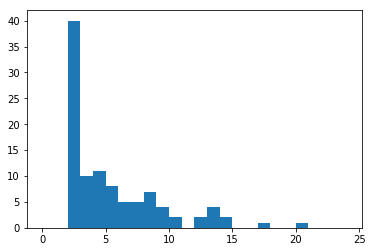

In [279]:
lengths = [v.length for k, v in trees.items()]
plt.hist(lengths, bins=np.arange(0, 25))

(array([ 0.,  0.,  5.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 24 Patch objects>)

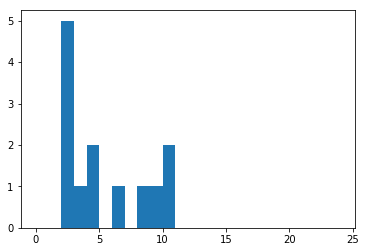

In [280]:
lengths = [v.length for k, v in filtered_trees.items()]
plt.hist(lengths, bins=np.arange(0, 25))

In [281]:
def vis_channel_maps(plot_data, plot_mask_data, plot_mask_corners, key, pre_pad=0, post_pad=0):
    fig, axs = plt.subplots(len(plot_data), 1, figsize=(4, 16))

    min_val, max_val = np.min(plot_data), np.max(plot_data)
    min_cut, max_cut = np.percentile(plot_data, 5), np.percentile(plot_data, 95)

    #ra, dec = galfa_util.galfa_index_to_radecs([plot_mask_corners[0][1], plot_mask_corners[1][1]],
    #                                           [plot_mask_corners[0][0], plot_mask_corners[1][0]])
    pad_slices = pre_pad + post_pad
    plot_mask_slices = [np.arange(pre_pad, )]
    for i, ax in enumerate(axs):
        plot_data[i, 0, 0] = min_cut
        plot_data[i, 0, 1] = max_cut
        ax.imshow(plot_data[i].clip(min_cut, max_cut), origin='lower', cmap='binary')

        
        if i >= pre_pad and i < len(data) - post_pad:
            ax.contour(plot_mask_data, alpha=.5, colors='red', linewidths=.3)

        #ax.set_xlabel('RA')
        #ax.set_ylabel('DEC')

        ax.set_yticks([0, plot_mask_corners[1][0]-plot_mask_corners[0][0]])
        #ax.set_yticklabels(np.round(dec,2))
        ax.set_xticks([0, plot_mask_corners[1][1]-plot_mask_corners[0][1]])
        #ax.set_xticklabels(np.round(ra,2))
        ax.set_title('{0} ({1})'.format(key, i-pre_pad))

    fig.tight_layout()
    fig.show()

In [282]:
short_filtered_trees = {k: v for k, v in filtered_trees.items() if v.length == 2}
ex_filtered_trees = {k: v for k, v in short_filtered_trees.items() if random.random() < .2}

In [283]:
ex_filtered_trees = {k: v for k, v in trees.items() if k == '520_2_0'}
print(len(ex_filtered_trees))

1


In [284]:
point_filtered_trees = tree_dict_util.find_trees_on_point(trees, point=(80, 320))

In [285]:
point_filtered_trees

{'1021_35_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x118e1a7a0>,
 '1070_6_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x119608878>,
 '1170_42_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x118e18c20>,
 '1173_25_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1187bd488>,
 '1307_27_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1187c4248>,
 '1373_17_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x118e01758>,
 '1384_39_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x11344fa28>,
 '1546_22_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x118e0d098>,
 '473_15_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x118e0dfc8>,
 '520_2_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1187be5a8>,
 '78

In [286]:
#filtered_trees['552_1_0'].length

[[49, 258], [110, 374]]


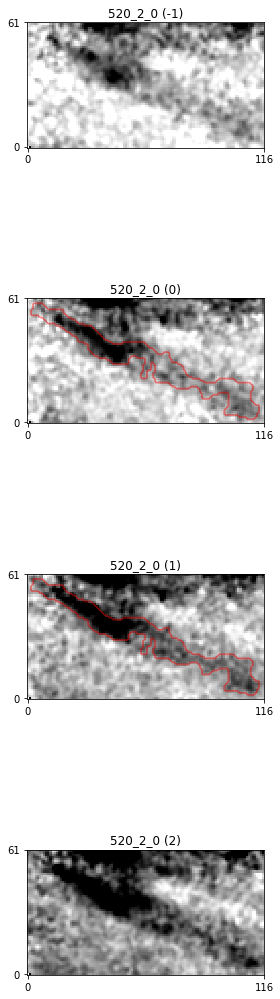

In [287]:
for k, tree in ex_filtered_trees.items():
    r_mask = tree.root_node.mask
    corners = tree.root_node.corners
    v_0 = tree.root_v_slice
    v_f = v_0 + tree.length
    pre_pad = 1
    post_pad = 1
    print(corners)
    data = high_lat_data[v_0 - pre_pad: v_f + post_pad,
                         corners[0][0]: corners[1][0],
                         corners[0][1]: corners[1][1]]
    vis_channel_maps(data, r_mask, corners, k, pre_pad=pre_pad, post_pad=post_pad)

In [130]:
filtered_nodes = tree_dict_util.find_nodes_on_point(nodes_dicts, point=(80, 320))

In [131]:
filtered_nodes

{0: {'745_0': <mask_obj_node.MaskObjNode instance at 0x11327b878>},
 1: {'552_0': <mask_obj_node.MaskObjNode instance at 0x1132ea128>},
 2: {'520_0': <mask_obj_node.MaskObjNode instance at 0x115795950>,
  '542_0': <mask_obj_node.MaskObjNode instance at 0x1157956c8>},
 3: {'1045_0': <mask_obj_node.MaskObjNode instance at 0x11579d6c8>},
 4: {'1222_0': <mask_obj_node.MaskObjNode instance at 0x11579f2d8>,
  '1298_0': <mask_obj_node.MaskObjNode instance at 0x11579c440>,
  '873_0': <mask_obj_node.MaskObjNode instance at 0x11579f128>},
 5: {'842_0': <mask_obj_node.MaskObjNode instance at 0x1157a5758>},
 6: {'1416_0': <mask_obj_node.MaskObjNode instance at 0x1157a8320>,
  '1835_0': <mask_obj_node.MaskObjNode instance at 0x1157a4cb0>},
 7: {'928_0': <mask_obj_node.MaskObjNode instance at 0x1157b0a70>},
 8: {'980_0': <mask_obj_node.MaskObjNode instance at 0x1157addd0>},
 9: {'735_0': <mask_obj_node.MaskObjNode instance at 0x1157bcb90>},
 10: {'729_0': <mask_obj_node.MaskObjNode instance at 0x115

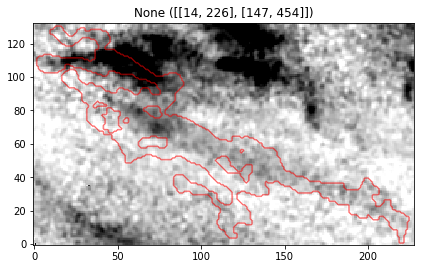

In [275]:
fig = node_vis.vis_mask_with_data(trees['552_1_0'].root_node, high_lat_data, return_fig=True)
fig.show()

NameError: name 'filterd_trees' is not defined

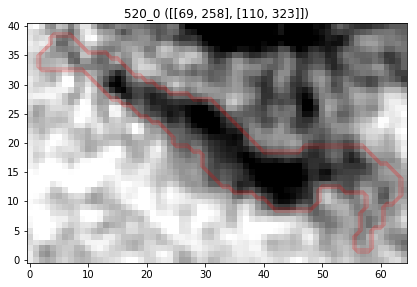

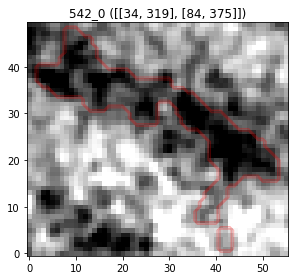

In [203]:
for k, v in filtered_nodes[2].items():
    fig = node_vis.vis_mask_with_data(v, high_lat_data, k, return_fig=True)
    fig.show()

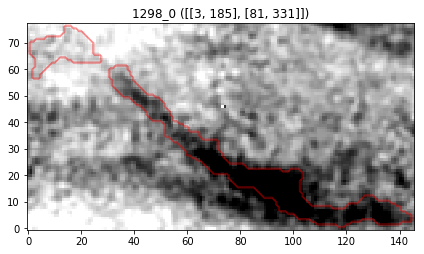

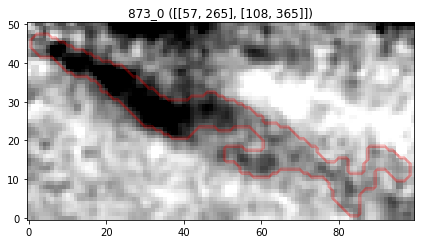

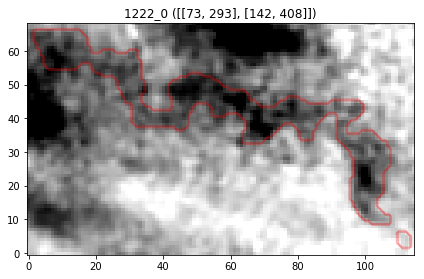

In [144]:
for k, v in filtered_nodes[4].items():
    fig = node_vis.vis_mask_with_data(v, high_lat_data, k, return_fig=True)
    fig.show()

In [158]:
filtered_nodes[3]['1045_0'].checkMaskOverlap(filtered_nodes[4]['873_0'], 0.85)

False

In [70]:
filtered_trees['863_45_0'].getLastNode().checkMaskOverlap(filtered_nodes[47]['1036_0'], 0.85)

True

In [69]:
filtered_trees['863_45_0'].getLastNode().v_slice_index

[46]

In [136]:
test_test_trees = find_trees(filtered_nodes)

INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 520_2_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 928_7_0
INFO:root:match found -- tree 928_7_0
INFO:root:match found -- tree 928_7_0
INFO:root:match found -- tree 928_7_0
INFO:root:match found -- tree 928_7_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 846_13_0
INFO:root:match found -- tree 846_13_0
INFO:root:no match found -- search

In [138]:
test_test_trees['520_2_0'].length

2

In [88]:
filtered_nodes_test = filtered_nodes
for k, v in nodes_dicts_clean[47].items():
    if k not in filtered_nodes_test[47]:
        filtered_nodes_test[47][k] = v
        logging.info('adding {0}'.format(k))
    test_test_trees = find_trees(filtered_nodes_test)
    if test_test_trees['863_45_0'].length != 3:
        break

INFO:root:adding 476_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1362_8_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INF

INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1362_8_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1376_13_0
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1333_19_0
INFO:root:match found -- tree 1333_19_0
INFO:root:match found -- tree 1333_19_0
INFO:root:match found -- tree 1

INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1362_8_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1376_13_0
INFO:root:no match found -- searched thro

INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:adding 1679_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched thro

INFO:root:match found -- tree 1417_27_0
INFO:root:match found -- tree 1417_27_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 926_38_0
INFO:root:match found -- tree 926_38_0
INFO:root:match found -- tree 926_38_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 863_45_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree

INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1362_8_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- t

INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 1417_27_0
INFO:root:match found -- tree 1417_27_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 926_38_0
INFO:root:match found -- tree 926_38_0
INFO:root:match found -- tree 926_38_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:match found -- tree 863_45_0
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree

INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict
INFO:root:no match found -- searched through tree dict


In [92]:
len(filtered_nodes_test[47])

21

In [93]:
len(nodes_dicts_clean[47])

19

In [91]:
{k for k in nodes_dicts_clean[47] if k not in filtered_nodes_test[47]}

set()

In [104]:
filtered_nodes_test[47]

{'1036_0': <mask_obj_node.MaskObjNode instance at 0x1179024d0>,
 '1173_0': <mask_obj_node.MaskObjNode instance at 0x117902ef0>,
 '1277_0': <mask_obj_node.MaskObjNode instance at 0x1179025a8>,
 '1292_0': <mask_obj_node.MaskObjNode instance at 0x1178f9050>,
 '1679_0': <mask_obj_node.MaskObjNode instance at 0x117902e18>,
 '366_0': <mask_obj_node.MaskObjNode instance at 0x1178ff5f0>,
 '376_0': <mask_obj_node.MaskObjNode instance at 0x1178ff368>,
 '377_0': <mask_obj_node.MaskObjNode instance at 0x117902b90>,
 '386_0': <mask_obj_node.MaskObjNode instance at 0x1178ff1b8>,
 '394_0': <mask_obj_node.MaskObjNode instance at 0x1178ff290>,
 '404_0': <mask_obj_node.MaskObjNode instance at 0x1178ff518>,
 '414_0': <mask_obj_node.MaskObjNode instance at 0x1179023f8>,
 '455_0': <mask_obj_node.MaskObjNode instance at 0x117902680>,
 '476_0': <mask_obj_node.MaskObjNode instance at 0x117902ab8>,
 '513_0': <mask_obj_node.MaskObjNode instance at 0x1179020e0>,
 '517_0': <mask_obj_node.MaskObjNode instance at 0

In [95]:
nodes_dicts_clean[47]

{'1173_0': <mask_obj_node.MaskObjNode instance at 0x117902ef0>,
 '1277_0': <mask_obj_node.MaskObjNode instance at 0x1179025a8>,
 '1679_0': <mask_obj_node.MaskObjNode instance at 0x117902e18>,
 '366_0': <mask_obj_node.MaskObjNode instance at 0x1178ff5f0>,
 '376_0': <mask_obj_node.MaskObjNode instance at 0x1178ff368>,
 '377_0': <mask_obj_node.MaskObjNode instance at 0x117902b90>,
 '386_0': <mask_obj_node.MaskObjNode instance at 0x1178ff1b8>,
 '394_0': <mask_obj_node.MaskObjNode instance at 0x1178ff290>,
 '404_0': <mask_obj_node.MaskObjNode instance at 0x1178ff518>,
 '414_0': <mask_obj_node.MaskObjNode instance at 0x1179023f8>,
 '455_0': <mask_obj_node.MaskObjNode instance at 0x117902680>,
 '476_0': <mask_obj_node.MaskObjNode instance at 0x117902ab8>,
 '513_0': <mask_obj_node.MaskObjNode instance at 0x1179020e0>,
 '517_0': <mask_obj_node.MaskObjNode instance at 0x1178ff440>,
 '522_0': <mask_obj_node.MaskObjNode instance at 0x117902fc8>,
 '557_0': <mask_obj_node.MaskObjNode instance at 0x1

In [112]:
filtered_nodes_test[47]['1036_0'].corners

[[35, 366], [84, 501]]

In [111]:
filtered_nodes_test[46]['714_0'].

[[46, 369], [83, 470]]